In [1]:
%reset -f
import numpy as np
import pandas as pd
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

2023-06-30 16:56:35.114691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 16:56:54.667778: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

In [3]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiratZion', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


In [4]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
167,2,134,toyota,gas,std,two,hardtop,rwd,front,98.40,...,146,mpfi,3.62,3.50,9.30,116,4800,24,30,8449
99,0,106,nissan,gas,std,four,hatchback,fwd,front,97.20,...,120,2bbl,3.33,3.47,8.50,97,5200,27,34,8949
121,1,154,plymouth,gas,std,four,sedan,fwd,front,93.70,...,90,2bbl,2.97,3.23,9.40,68,5500,31,38,6692


In [8]:
LABEL = 'price'

numeric_feature_names = car_data[['symboling','normalized-losses','wheel-base','engine-size','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']]
categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

print(len(numeric_feature_names))
print(len(categorical_feature_names))
# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

205
14


AssertionError: 

In [10]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [11]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [12]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
9,0,?,99.50,178.20,67.90,52.00,3053,131,160,5500,16,22,3.13,3.40,7.00
16,0,?,103.50,193.80,67.90,53.70,3380,209,182,5400,16,22,3.62,3.39,8.00
113,0,?,114.20,198.90,68.40,56.70,3285,120,95,5000,19,24,3.46,2.19,8.40
194,-2,103,104.30,188.80,67.20,56.20,2912,141,114,5400,23,28,3.78,3.15,9.50
167,2,134,98.40,176.20,65.60,52.00,2540,146,116,4800,24,30,3.62,3.50,9.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,1,107,96.50,169.10,66.00,51.00,2293,110,100,5500,25,31,3.15,3.58,9.10
108,0,161,107.90,186.70,68.40,56.70,3197,152,95,4150,28,33,3.70,3.52,21.00
175,-1,65,102.40,175.60,66.50,53.90,2414,122,92,4200,27,32,3.31,3.54,8.70
39,0,85,96.50,175.40,65.20,54.10,2304,110,86,5800,27,33,3.15,3.58,9.00


In [13]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,fuel-system,engine-location,body-style,aspiration,make,num-doors,fuel-type,engine-type,num-cylinders,drive-wheels
9,mpfi,front,hatchback,turbo,audi,two,gas,ohc,five,4wd
16,mpfi,front,sedan,std,bmw,two,gas,ohc,six,rwd
113,mpfi,front,wagon,std,peugot,four,gas,l,four,rwd
194,mpfi,front,sedan,std,volvo,four,gas,ohc,four,rwd
167,mpfi,front,hardtop,std,toyota,two,gas,ohc,four,rwd
...,...,...,...,...,...,...,...,...,...,...
42,2bbl,front,sedan,std,honda,two,gas,ohc,four,fwd
108,idi,front,sedan,turbo,peugot,four,diesel,l,four,rwd
175,mpfi,front,hatchback,std,toyota,four,gas,ohc,four,fwd
39,1bbl,front,sedan,std,honda,four,gas,ohc,four,fwd


In [14]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

In [16]:
# This code "works", but because of bad hyperparameter choices it gets NaN loss
# during training. Try fixing this.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

2023-06-30 17:04:36.086954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:04:36.087267: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpku240nnc/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 4937048000.0, step = 1
ERROR:tensorflow:Model diverged with loss = NaN.


NanLossDuringTrainingError: NaN loss during training.

In [17]:
#@title Possible solution
# Here is one possible solution:
# The only necessary change to fix the NaN training loss was the choice of optimizer.

# Changing other parameters could improve model quality, but take it with a
# grain of salt. The dataset is very small.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

2023-06-30 17:05:30.242981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:30.243284: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpq16jwi_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 3827364400.0, step = 1
INFO:tensorflow:global_step/sec: 320.915
INFO:tensorflow:loss = 210984160.0, step = 101 (0.313 sec)
INFO:tensorflow:global_step/sec: 384.61
INFO:tensorflow:loss = 1642043600.0, step = 201 (0.261 sec)
INFO:tensorflow:global_step/sec: 422.91
INFO:tensorflow:loss = 555817660.0, step = 301 (0.237 sec)
INFO:tensorflow:global_step/sec: 413.659
INFO:tensorflow:loss = 1524155100.0, step = 401 (0.243 sec)
INFO:tensorflow:global_step/sec: 409.945
INFO:tensorflow:loss = 1323395800.0, step = 501 (0.245 sec)
INFO:tensorflow:global_step/sec: 396.938
INFO:tensorflow:loss = 1043404600.0, step = 601 (0.249 sec)
INFO:tensorflow:global_step/sec: 431.065
INFO:tensorflow:loss = 970070100.0, step = 701 (0.235 sec)
INFO:tensorflow:global_step/

2023-06-30 17:05:34.008588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:34.008893: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.46971s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:05:34
INFO:tensorflow:Saving dict for global step 1000: average_loss = 39916908.0, global_step = 1000, label/mean = 12949.43, loss = 629458900.0, prediction/mean = 13255.167
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpq16jwi_6/model.ckpt-1000
scores {'average_loss': 39916908.0, 'label/mean': 12949.43, 'loss': 629458900.0, 'prediction/mean': 13255.167, 'global_step': 1000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq16jwi_6/model.ckpt-1000
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:05:34.936797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:34.937116: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...
INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpq16jwi_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...
INFO:tensorflow:loss = 645553900.0, step = 1001
INFO:tensorflow:global_step/sec: 408.156
INFO:tensorflow:loss = 1821562600.0, step = 1101 (0.247 sec)
INFO:tensorflow:global_step/sec: 401.914
INFO:tensorflow:loss = 315278140.0, step = 1201 (0.249 sec)
INFO:tensorflow:global_step/sec: 384.231
INFO:tensorflow:loss = 206400050.0, step = 1301 (0.261 sec)
INFO:tensorflow:global_step/sec: 417.087
INFO:tensorflow:loss = 820997100.0, step = 1401 (0.240 sec)
INFO:tensorflow:global_step/sec: 416.185
INFO:tensorflow:loss = 240255630.0, step = 1501 (0.240 sec)
INFO:tensorflow:global_step/sec: 423.973
INFO:tensorflow:loss = 152971780.0, step = 1601 (0.235 sec)
INFO:tensorflow:global_step/sec: 399.086
INFO:tensorflow:loss = 737046000.0, step = 1701 (0.252 sec)
INFO:tensor

2023-06-30 17:05:38.601848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:38.602114: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.36012s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:05:38
INFO:tensorflow:Saving dict for global step 2000: average_loss = 30963434.0, global_step = 2000, label/mean = 12949.43, loss = 488269540.0, prediction/mean = 13344.333
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpq16jwi_6/model.ckpt-2000
scores {'average_loss': 30963434.0, 'label/mean': 12949.43, 'loss': 488269540.0, 'prediction/mean': 13344.333, 'global_step': 2000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq16jwi_6/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:05:39.291904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:39.292175: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2000...
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpq16jwi_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2000...
INFO:tensorflow:loss = 454687500.0, step = 2001
INFO:tensorflow:global_step/sec: 408.42
INFO:tensorflow:loss = 877015300.0, step = 2101 (0.247 sec)
INFO:tensorflow:global_step/sec: 378.692
INFO:tensorflow:loss = 176595040.0, step = 2201 (0.266 sec)
INFO:tensorflow:global_step/sec: 427.99
INFO:tensorflow:loss = 242623360.0, step = 2301 (0.233 sec)
INFO:tensorflow:global_step/sec: 426.95
INFO:tensorflow:loss = 192888830.0, step = 2401 (0.233 sec)
INFO:tensorflow:global_step/sec: 438.753
INFO:tensorflow:loss = 194040700.0, step = 2501 (0.228 sec)
INFO:tensorflow:global_step/sec: 409.634
INFO:tensorflow:loss = 317726300.0, step = 2601 (0.246 sec)
INFO:tensorflow:global_step/sec: 433.826
INFO:tensorflow:loss = 214779790.0, step = 2701 (0.229 sec)
INFO:tensorflow

2023-06-30 17:05:42.946247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:42.946529: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.36701s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:05:43
INFO:tensorflow:Saving dict for global step 3000: average_loss = 27322848.0, global_step = 3000, label/mean = 12949.43, loss = 430860300.0, prediction/mean = 13189.212
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /tmp/tmpq16jwi_6/model.ckpt-3000
scores {'average_loss': 27322848.0, 'label/mean': 12949.43, 'loss': 430860300.0, 'prediction/mean': 13189.212, 'global_step': 3000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq16jwi_6/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:05:43.652662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:43.652966: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...
INFO:tensorflow:Saving checkpoints for 3000 into /tmp/tmpq16jwi_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...
INFO:tensorflow:loss = 162952670.0, step = 3001
INFO:tensorflow:global_step/sec: 415.727
INFO:tensorflow:loss = 202376910.0, step = 3101 (0.243 sec)
INFO:tensorflow:global_step/sec: 420.346
INFO:tensorflow:loss = 257101600.0, step = 3201 (0.238 sec)
INFO:tensorflow:global_step/sec: 445.42
INFO:tensorflow:loss = 311929470.0, step = 3301 (0.225 sec)
INFO:tensorflow:global_step/sec: 387.339
INFO:tensorflow:loss = 504946370.0, step = 3401 (0.260 sec)
INFO:tensorflow:global_step/sec: 398.333
INFO:tensorflow:loss = 627791740.0, step = 3501 (0.250 sec)
INFO:tensorflow:global_step/sec: 419.977
INFO:tensorflow:loss = 136810740.0, step = 3601 (0.239 sec)
INFO:tensorflow:global_step/sec: 436.261
INFO:tensorflow:loss = 162704720.0, step = 3701 (0.228 sec)
INFO:tensorfl

2023-06-30 17:05:47.255303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:47.255587: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.38241s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:05:47
INFO:tensorflow:Saving dict for global step 4000: average_loss = 25764724.0, global_step = 4000, label/mean = 12949.43, loss = 406289900.0, prediction/mean = 13149.163
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: /tmp/tmpq16jwi_6/model.ckpt-4000
scores {'average_loss': 25764724.0, 'label/mean': 12949.43, 'loss': 406289900.0, 'prediction/mean': 13149.163, 'global_step': 4000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq16jwi_6/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:05:48.183209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:48.183564: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4000...
INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpq16jwi_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4000...
INFO:tensorflow:loss = 421960350.0, step = 4001
INFO:tensorflow:global_step/sec: 424.728
INFO:tensorflow:loss = 153580160.0, step = 4101 (0.238 sec)
INFO:tensorflow:global_step/sec: 365.962
INFO:tensorflow:loss = 486392900.0, step = 4201 (0.273 sec)
INFO:tensorflow:global_step/sec: 386.356
INFO:tensorflow:loss = 167022160.0, step = 4301 (0.262 sec)
INFO:tensorflow:global_step/sec: 380.695
INFO:tensorflow:loss = 168475550.0, step = 4401 (0.261 sec)
INFO:tensorflow:global_step/sec: 388.25
INFO:tensorflow:loss = 60931456.0, step = 4501 (0.256 sec)
INFO:tensorflow:global_step/sec: 398.023
INFO:tensorflow:loss = 642283970.0, step = 4601 (0.252 sec)
INFO:tensorflow:global_step/sec: 388.138
INFO:tensorflow:loss = 791999170.0, step = 4701 (0.258 sec)
INFO:tensorflo

2023-06-30 17:05:51.889887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:51.890176: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.36934s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:05:52
INFO:tensorflow:Saving dict for global step 5000: average_loss = 25011824.0, global_step = 5000, label/mean = 12949.43, loss = 394417200.0, prediction/mean = 13049.106
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpq16jwi_6/model.ckpt-5000
scores {'average_loss': 25011824.0, 'label/mean': 12949.43, 'loss': 394417200.0, 'prediction/mean': 13049.106, 'global_step': 5000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq16jwi_6/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:05:52.630361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:52.630668: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5000...
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmpq16jwi_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5000...
INFO:tensorflow:loss = 617773250.0, step = 5001
INFO:tensorflow:global_step/sec: 416.02
INFO:tensorflow:loss = 362245860.0, step = 5101 (0.242 sec)
INFO:tensorflow:global_step/sec: 451.059
INFO:tensorflow:loss = 942116800.0, step = 5201 (0.224 sec)
INFO:tensorflow:global_step/sec: 430.84
INFO:tensorflow:loss = 232664240.0, step = 5301 (0.233 sec)
INFO:tensorflow:global_step/sec: 432.793
INFO:tensorflow:loss = 250939360.0, step = 5401 (0.231 sec)
INFO:tensorflow:global_step/sec: 366.414
INFO:tensorflow:loss = 644718100.0, step = 5501 (0.272 sec)
INFO:tensorflow:global_step/sec: 434.241
INFO:tensorflow:loss = 86435200.0, step = 5601 (0.229 sec)
INFO:tensorflow:global_step/sec: 368.805
INFO:tensorflow:loss = 138607000.0, step = 5701 (0.273 sec)
INFO:tensorflow

2023-06-30 17:05:56.244777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:56.245049: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.36105s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:05:56
INFO:tensorflow:Saving dict for global step 6000: average_loss = 24545408.0, global_step = 6000, label/mean = 12949.43, loss = 387062200.0, prediction/mean = 13047.31
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /tmp/tmpq16jwi_6/model.ckpt-6000
scores {'average_loss': 24545408.0, 'label/mean': 12949.43, 'loss': 387062200.0, 'prediction/mean': 13047.31, 'global_step': 6000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq16jwi_6/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:05:56.985341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:05:56.985614: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...
INFO:tensorflow:Saving checkpoints for 6000 into /tmp/tmpq16jwi_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...
INFO:tensorflow:loss = 577219200.0, step = 6001
INFO:tensorflow:global_step/sec: 368.083
INFO:tensorflow:loss = 119426500.0, step = 6101 (0.274 sec)
INFO:tensorflow:global_step/sec: 441.85
INFO:tensorflow:loss = 153209500.0, step = 6201 (0.226 sec)
INFO:tensorflow:global_step/sec: 361.525
INFO:tensorflow:loss = 205638000.0, step = 6301 (0.277 sec)
INFO:tensorflow:global_step/sec: 370.39
INFO:tensorflow:loss = 432970050.0, step = 6401 (0.273 sec)
INFO:tensorflow:global_step/sec: 230.983
INFO:tensorflow:loss = 446947200.0, step = 6501 (0.431 sec)
INFO:tensorflow:global_step/sec: 288.254
INFO:tensorflow:loss = 340651520.0, step = 6601 (0.349 sec)
INFO:tensorflow:global_step/sec: 396.02
INFO:tensorflow:loss = 813729900.0, step = 6701 (0.250 sec)
INFO:tensorflow

2023-06-30 17:06:00.948166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:00.948441: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.34416s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:06:01
INFO:tensorflow:Saving dict for global step 7000: average_loss = 24222834.0, global_step = 7000, label/mean = 12949.43, loss = 381975500.0, prediction/mean = 13222.528
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7000: /tmp/tmpq16jwi_6/model.ckpt-7000
scores {'average_loss': 24222834.0, 'label/mean': 12949.43, 'loss': 381975500.0, 'prediction/mean': 13222.528, 'global_step': 7000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq16jwi_6/model.ckpt-7000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:06:01.634735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:01.635022: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7000...
INFO:tensorflow:Saving checkpoints for 7000 into /tmp/tmpq16jwi_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7000...
INFO:tensorflow:loss = 805592100.0, step = 7001
INFO:tensorflow:global_step/sec: 387.428
INFO:tensorflow:loss = 483272000.0, step = 7101 (0.262 sec)
INFO:tensorflow:global_step/sec: 409.221
INFO:tensorflow:loss = 508105400.0, step = 7201 (0.246 sec)
INFO:tensorflow:global_step/sec: 396.278
INFO:tensorflow:loss = 627417400.0, step = 7301 (0.250 sec)
INFO:tensorflow:global_step/sec: 395.471
INFO:tensorflow:loss = 513017400.0, step = 7401 (0.255 sec)
INFO:tensorflow:global_step/sec: 420.218
INFO:tensorflow:loss = 201773940.0, step = 7501 (0.237 sec)
INFO:tensorflow:global_step/sec: 409.798
INFO:tensorflow:loss = 127623360.0, step = 7601 (0.244 sec)
INFO:tensorflow:global_step/sec: 340.226
INFO:tensorflow:loss = 818628740.0, step = 7701 (0.293 sec)
INFO:tensorf

2023-06-30 17:06:05.451054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:05.451348: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.37098s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:06:05
INFO:tensorflow:Saving dict for global step 8000: average_loss = 23965736.0, global_step = 8000, label/mean = 12949.43, loss = 377921200.0, prediction/mean = 13194.257
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8000: /tmp/tmpq16jwi_6/model.ckpt-8000
scores {'average_loss': 23965736.0, 'label/mean': 12949.43, 'loss': 377921200.0, 'prediction/mean': 13194.257, 'global_step': 8000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq16jwi_6/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:06:06.171873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:06.172162: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8000...
INFO:tensorflow:Saving checkpoints for 8000 into /tmp/tmpq16jwi_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...
INFO:tensorflow:loss = 277730370.0, step = 8001
INFO:tensorflow:global_step/sec: 341.122
INFO:tensorflow:loss = 264722260.0, step = 8101 (0.297 sec)
INFO:tensorflow:global_step/sec: 422.907
INFO:tensorflow:loss = 232118400.0, step = 8201 (0.234 sec)
INFO:tensorflow:global_step/sec: 350.441
INFO:tensorflow:loss = 149429620.0, step = 8301 (0.286 sec)
INFO:tensorflow:global_step/sec: 383.79
INFO:tensorflow:loss = 697805200.0, step = 8401 (0.260 sec)
INFO:tensorflow:global_step/sec: 376.343
INFO:tensorflow:loss = 144283200.0, step = 8501 (0.268 sec)
INFO:tensorflow:global_step/sec: 379.412
INFO:tensorflow:loss = 196406720.0, step = 8601 (0.261 sec)
INFO:tensorflow:global_step/sec: 401.922
INFO:tensorflow:loss = 122457210.0, step = 8701 (0.248 sec)
INFO:tensorfl

2023-06-30 17:06:09.888183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:09.888447: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.34284s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:06:10
INFO:tensorflow:Saving dict for global step 9000: average_loss = 23748678.0, global_step = 9000, label/mean = 12949.43, loss = 374498370.0, prediction/mean = 13172.683
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /tmp/tmpq16jwi_6/model.ckpt-9000
scores {'average_loss': 23748678.0, 'label/mean': 12949.43, 'loss': 374498370.0, 'prediction/mean': 13172.683, 'global_step': 9000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq16jwi_6/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:06:10.560044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:10.560308: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tmpq16jwi_6/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...
INFO:tensorflow:loss = 117487660.0, step = 9001
INFO:tensorflow:global_step/sec: 421.684
INFO:tensorflow:loss = 492509950.0, step = 9101 (0.241 sec)
INFO:tensorflow:global_step/sec: 446.455
INFO:tensorflow:loss = 284480580.0, step = 9201 (0.222 sec)
INFO:tensorflow:global_step/sec: 431.374
INFO:tensorflow:loss = 272082620.0, step = 9301 (0.232 sec)
INFO:tensorflow:global_step/sec: 443.246
INFO:tensorflow:loss = 251283220.0, step = 9401 (0.230 sec)
INFO:tensorflow:global_step/sec: 390.93
INFO:tensorflow:loss = 135369390.0, step = 9501 (0.251 sec)
INFO:tensorflow:global_step/sec: 401.713
INFO:tensorflow:loss = 159207800.0, step = 9601 (0.249 sec)
INFO:tensorflow:global_step/sec: 426.983
INFO:tensorflow:loss = 155656830.0, step = 9701 (0.234 sec)
INFO:tensorfl

2023-06-30 17:06:14.105506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:14.105800: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.37024s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:06:14
INFO:tensorflow:Saving dict for global step 10000: average_loss = 23551134.0, global_step = 10000, label/mean = 12949.43, loss = 371383260.0, prediction/mean = 13106.323
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmpq16jwi_6/model.ckpt-10000
scores {'average_loss': 23551134.0, 'label/mean': 12949.43, 'loss': 371383260.0, 'prediction/mean': 13106.323, 'global_step': 10000}


INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpq16jwi_6/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:06:23.968851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:23.969185: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


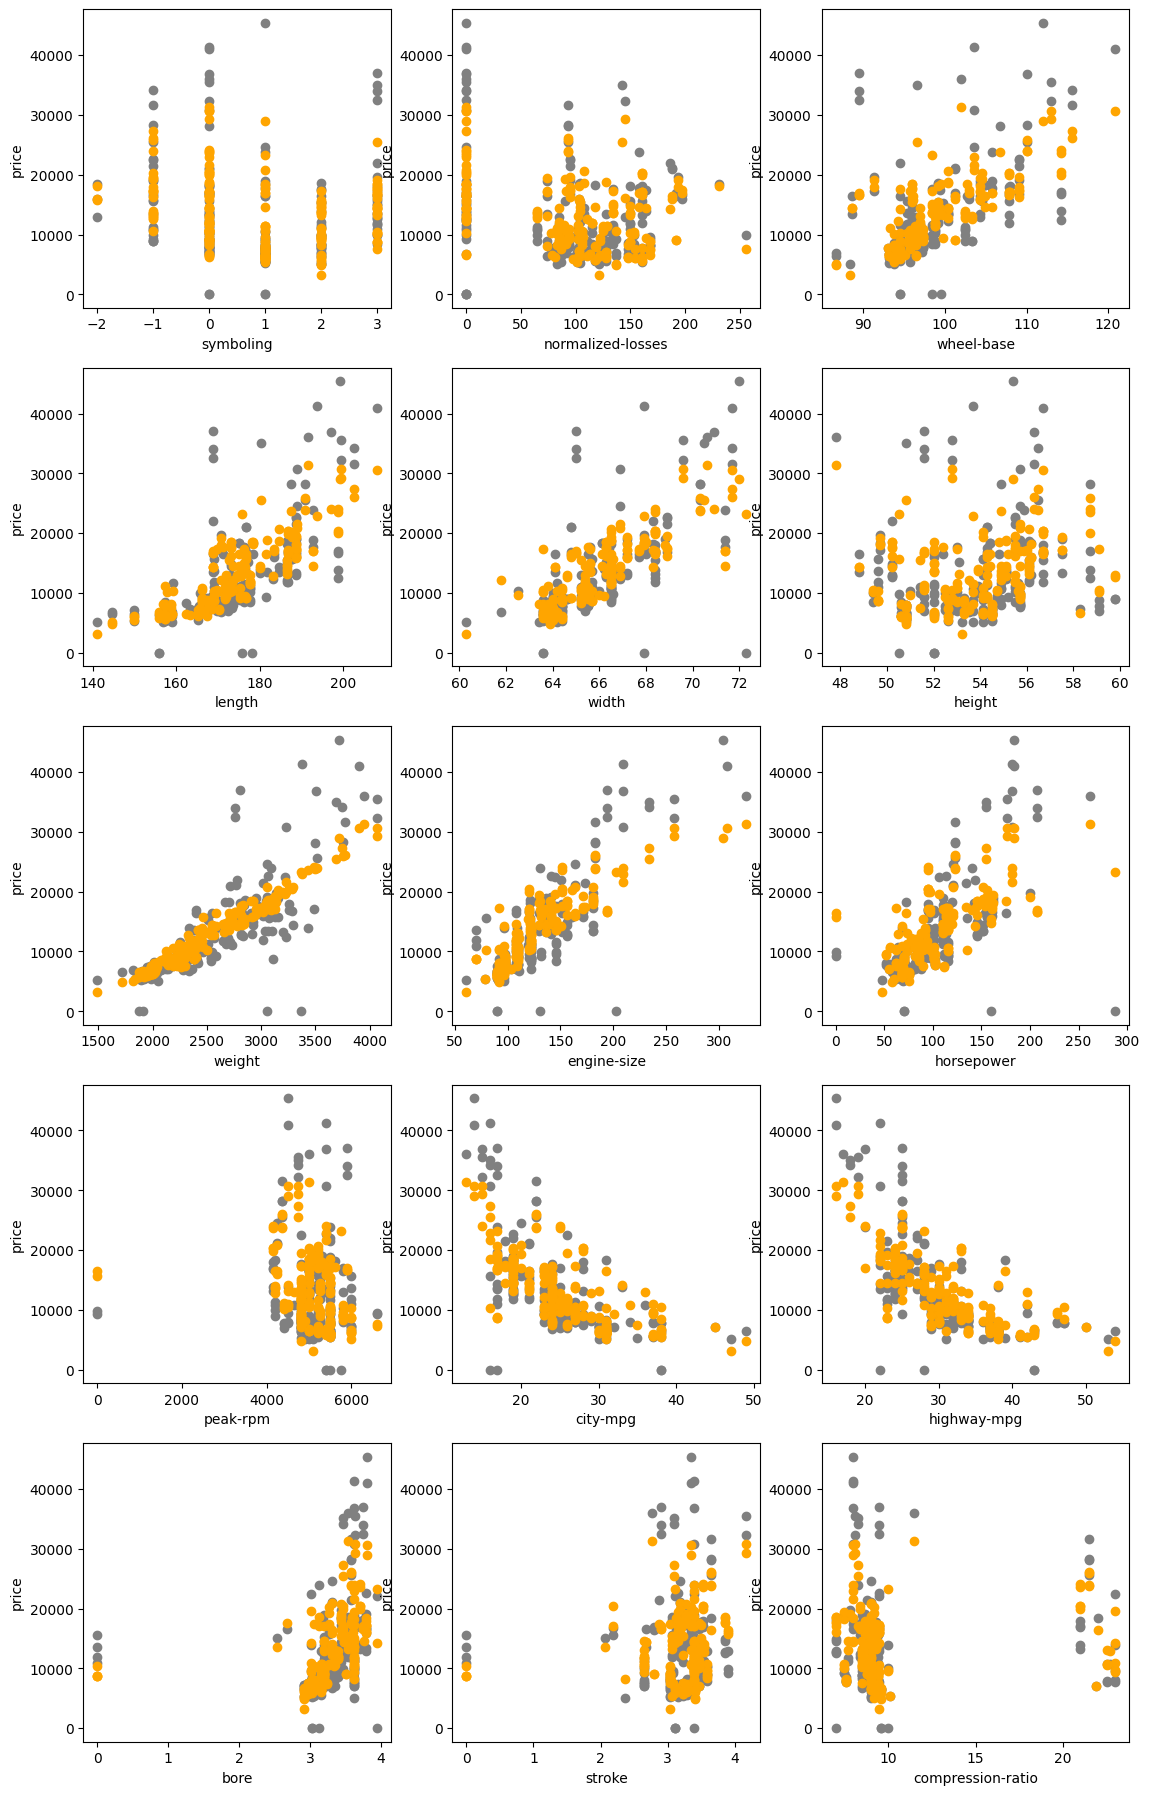

In [18]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.
  
  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]
  
  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)
  
  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

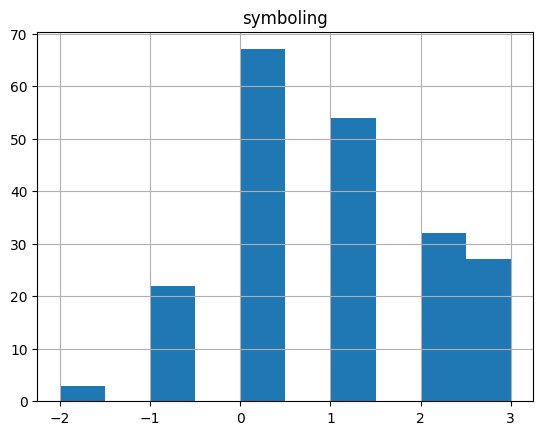

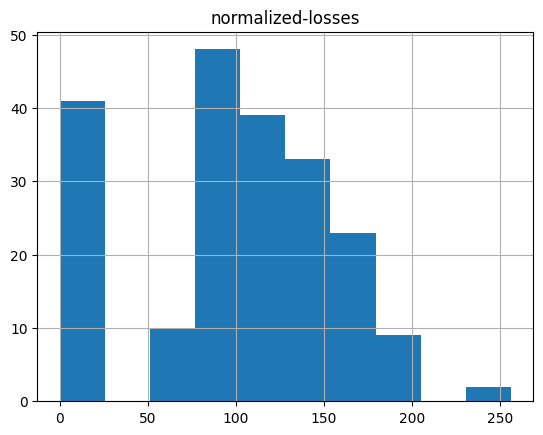

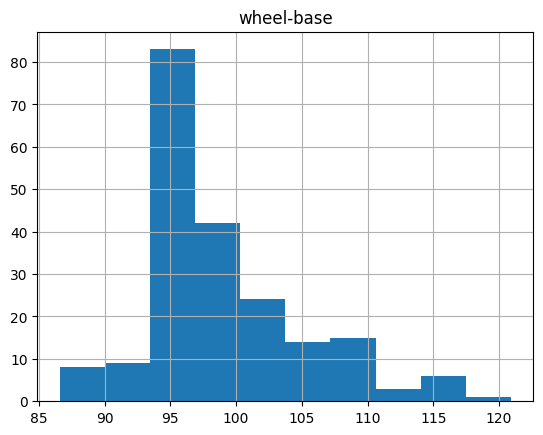

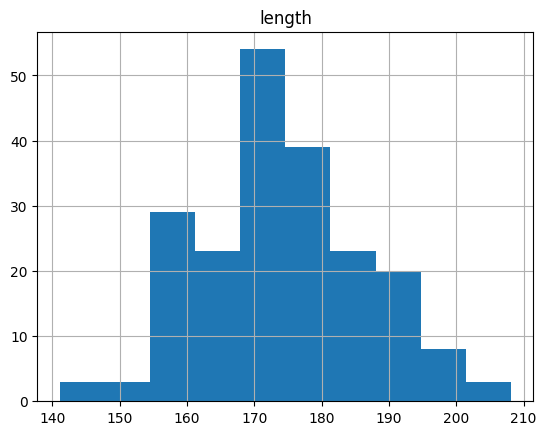

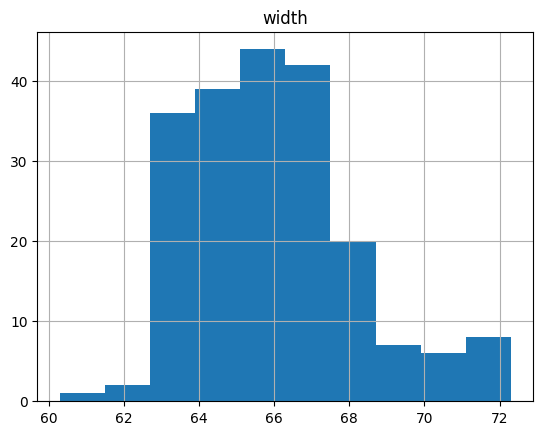

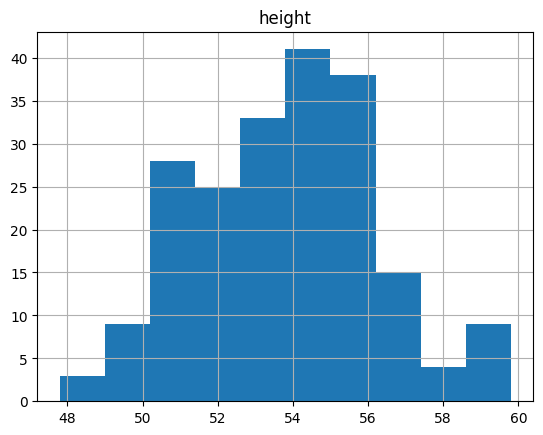

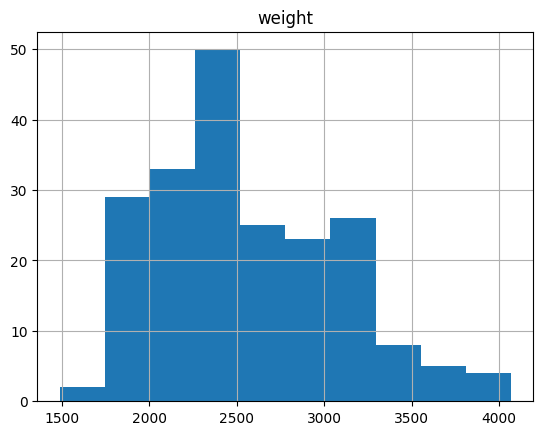

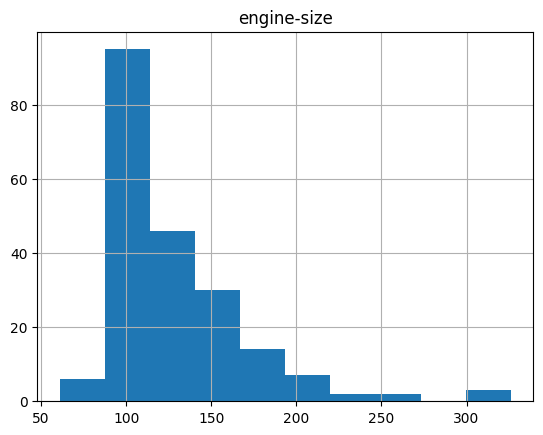

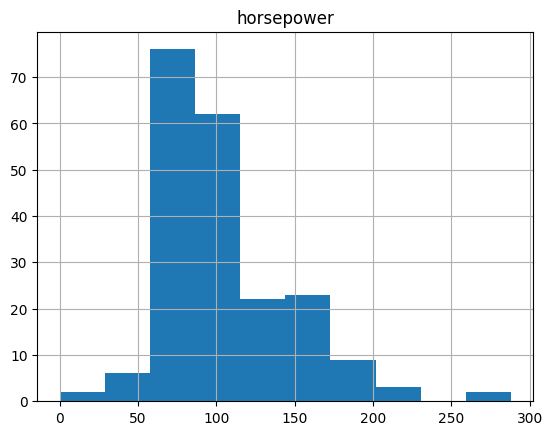

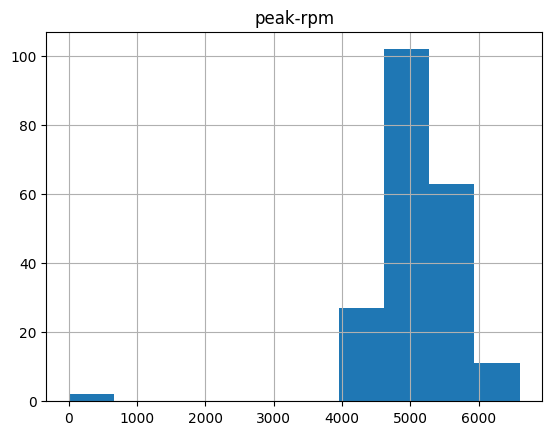

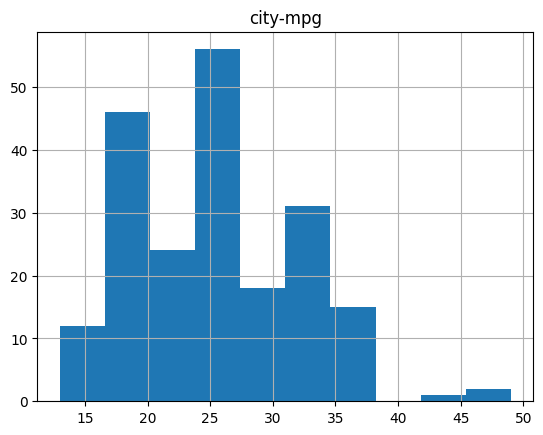

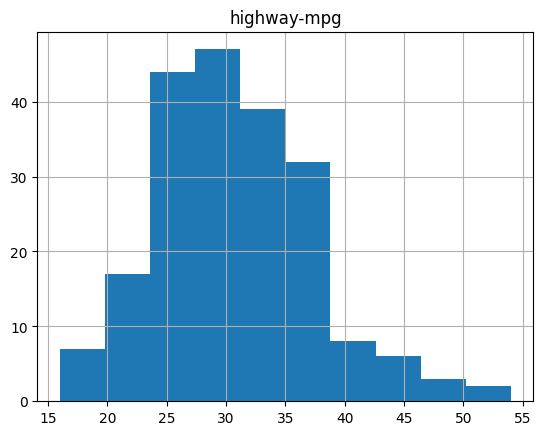

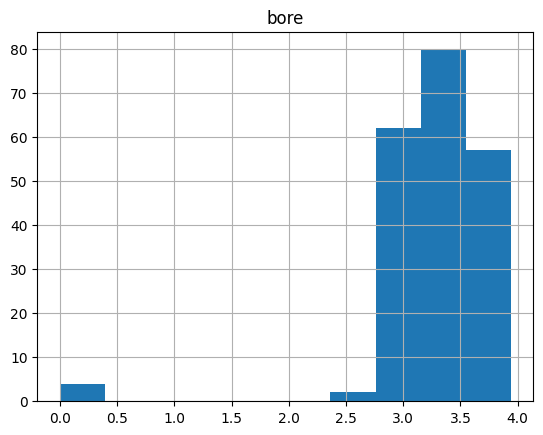

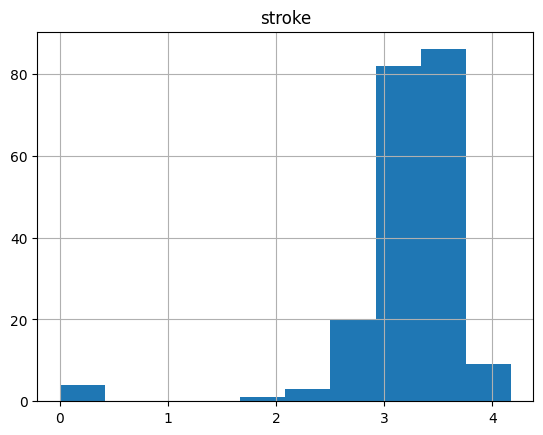

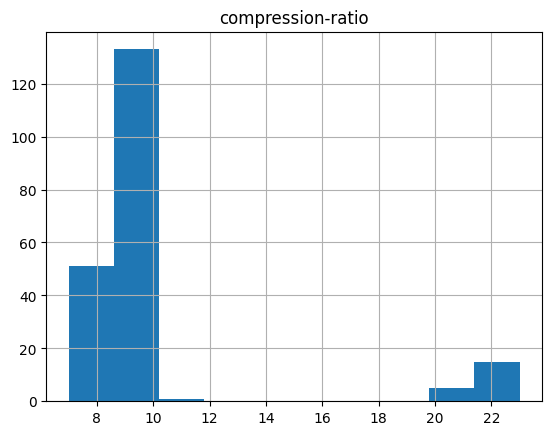

In [19]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7ff6cc468ca0>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7ff6cc4101f0>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7ff6cc610160>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7ff6af588d30>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7ff6af5891b0>), NumericColumn(key='height', shape=(1,), default_va

2023-06-30 17:06:36.374151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:36.374421: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp0i992nld/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2930090000.0, step = 1
INFO:tensorflow:global_step/sec: 373.425
INFO:tensorflow:loss = 1966371600.0, step = 101 (0.271 sec)
INFO:tensorflow:global_step/sec: 409.869
INFO:tensorflow:loss = 987658750.0, step = 201 (0.244 sec)
INFO:tensorflow:global_step/sec: 378.015
INFO:tensorflow:loss = 396640450.0, step = 301 (0.267 sec)
INFO:tensorflow:global_step/sec: 412.053
INFO:tensorflow:loss = 747420160.0, step = 401 (0.242 sec)
INFO:tensorflow:global_step/sec: 397.232
INFO:tensorflow:loss = 621688700.0, step = 501 (0.251 sec)
INFO:tensorflow:global_step/sec: 367.084
INFO:tensorflow:loss = 1962691600.0, step = 601 (0.273 sec)
INFO:tensorflow:global_step/sec: 408.054
INFO:tensorflow:loss = 482626300.0, step = 701 (0.246 sec)
INFO:tensorflow:global_step/

2023-06-30 17:06:40.240319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:40.240650: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.40302s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:06:40
INFO:tensorflow:Saving dict for global step 1000: average_loss = 50350030.0, global_step = 1000, label/mean = 12949.43, loss = 793981250.0, prediction/mean = 13140.531
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp0i992nld/model.ckpt-1000
scores {'average_loss': 50350030.0, 'label/mean': 12949.43, 'loss': 793981250.0, 'prediction/mean': 13140.531, 'global_step': 1000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0i992nld/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:06:41.174556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:41.174821: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...
INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmp0i992nld/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...
INFO:tensorflow:loss = 1848386800.0, step = 1001
INFO:tensorflow:global_step/sec: 363.993
INFO:tensorflow:loss = 722716700.0, step = 1101 (0.278 sec)
INFO:tensorflow:global_step/sec: 402.632
INFO:tensorflow:loss = 731289340.0, step = 1201 (0.247 sec)
INFO:tensorflow:global_step/sec: 415.854
INFO:tensorflow:loss = 345849300.0, step = 1301 (0.241 sec)
INFO:tensorflow:global_step/sec: 436.364
INFO:tensorflow:loss = 393128220.0, step = 1401 (0.230 sec)
INFO:tensorflow:global_step/sec: 418.358
INFO:tensorflow:loss = 1443908200.0, step = 1501 (0.236 sec)
INFO:tensorflow:global_step/sec: 396.226
INFO:tensorflow:loss = 710416400.0, step = 1601 (0.254 sec)
INFO:tensorflow:global_step/sec: 371.404
INFO:tensorflow:loss = 583003140.0, step = 1701 (0.270 sec)
INFO:tenso

2023-06-30 17:06:44.907041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:44.907352: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.37916s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:06:45
INFO:tensorflow:Saving dict for global step 2000: average_loss = 43354210.0, global_step = 2000, label/mean = 12949.43, loss = 683662460.0, prediction/mean = 13244.235
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmp0i992nld/model.ckpt-2000
scores {'average_loss': 43354210.0, 'label/mean': 12949.43, 'loss': 683662460.0, 'prediction/mean': 13244.235, 'global_step': 2000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0i992nld/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:06:46.049291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:46.049630: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2000...
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp0i992nld/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2000...
INFO:tensorflow:loss = 501659680.0, step = 2001
INFO:tensorflow:global_step/sec: 368.763
INFO:tensorflow:loss = 567229000.0, step = 2101 (0.274 sec)
INFO:tensorflow:global_step/sec: 406.011
INFO:tensorflow:loss = 446754940.0, step = 2201 (0.248 sec)
INFO:tensorflow:global_step/sec: 419.596
INFO:tensorflow:loss = 629914300.0, step = 2301 (0.237 sec)
INFO:tensorflow:global_step/sec: 402.101
INFO:tensorflow:loss = 1717717800.0, step = 2401 (0.249 sec)
INFO:tensorflow:global_step/sec: 412.547
INFO:tensorflow:loss = 521309570.0, step = 2501 (0.242 sec)
INFO:tensorflow:global_step/sec: 385.372
INFO:tensorflow:loss = 152790960.0, step = 2601 (0.259 sec)
INFO:tensorflow:global_step/sec: 377.775
INFO:tensorflow:loss = 187283900.0, step = 2701 (0.266 sec)
INFO:tensor

2023-06-30 17:06:49.904768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:49.905084: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.38722s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:06:50
INFO:tensorflow:Saving dict for global step 3000: average_loss = 38363010.0, global_step = 3000, label/mean = 12949.43, loss = 604955100.0, prediction/mean = 13224.661
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /tmp/tmp0i992nld/model.ckpt-3000
scores {'average_loss': 38363010.0, 'label/mean': 12949.43, 'loss': 604955100.0, 'prediction/mean': 13224.661, 'global_step': 3000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0i992nld/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:06:50.712952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:50.713241: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...
INFO:tensorflow:Saving checkpoints for 3000 into /tmp/tmp0i992nld/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...
INFO:tensorflow:loss = 482792030.0, step = 3001
INFO:tensorflow:global_step/sec: 264.387
INFO:tensorflow:loss = 179561680.0, step = 3101 (0.382 sec)
INFO:tensorflow:global_step/sec: 311.745
INFO:tensorflow:loss = 1050902000.0, step = 3201 (0.322 sec)
INFO:tensorflow:global_step/sec: 290.805
INFO:tensorflow:loss = 117395400.0, step = 3301 (0.342 sec)
INFO:tensorflow:global_step/sec: 356.272
INFO:tensorflow:loss = 553733700.0, step = 3401 (0.280 sec)
INFO:tensorflow:global_step/sec: 361.65
INFO:tensorflow:loss = 646532100.0, step = 3501 (0.279 sec)
INFO:tensorflow:global_step/sec: 356.704
INFO:tensorflow:loss = 148433730.0, step = 3601 (0.279 sec)
INFO:tensorflow:global_step/sec: 372.404
INFO:tensorflow:loss = 313963870.0, step = 3701 (0.268 sec)
INFO:tensorf

2023-06-30 17:06:55.039329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:55.039591: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.39722s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:06:55
INFO:tensorflow:Saving dict for global step 4000: average_loss = 34707844.0, global_step = 4000, label/mean = 12949.43, loss = 547316030.0, prediction/mean = 13236.638
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: /tmp/tmp0i992nld/model.ckpt-4000
scores {'average_loss': 34707844.0, 'label/mean': 12949.43, 'loss': 547316030.0, 'prediction/mean': 13236.638, 'global_step': 4000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0i992nld/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:06:55.910991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:06:55.911266: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4000...
INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmp0i992nld/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4000...
INFO:tensorflow:loss = 328227170.0, step = 4001
INFO:tensorflow:global_step/sec: 319.982
INFO:tensorflow:loss = 174813310.0, step = 4101 (0.316 sec)
INFO:tensorflow:global_step/sec: 337.713
INFO:tensorflow:loss = 605467800.0, step = 4201 (0.297 sec)
INFO:tensorflow:global_step/sec: 257.061
INFO:tensorflow:loss = 270384320.0, step = 4301 (0.390 sec)
INFO:tensorflow:global_step/sec: 312.783
INFO:tensorflow:loss = 140545220.0, step = 4401 (0.318 sec)
INFO:tensorflow:global_step/sec: 336.815
INFO:tensorflow:loss = 624906900.0, step = 4501 (0.297 sec)
INFO:tensorflow:global_step/sec: 340.314
INFO:tensorflow:loss = 209353500.0, step = 4601 (0.292 sec)
INFO:tensorflow:global_step/sec: 347.695
INFO:tensorflow:loss = 148713800.0, step = 4701 (0.291 sec)
INFO:tensorf

2023-06-30 17:07:00.488274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:00.488577: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.41390s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:00
INFO:tensorflow:Saving dict for global step 5000: average_loss = 32012656.0, global_step = 5000, label/mean = 12949.43, loss = 504814940.0, prediction/mean = 13121.47
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp0i992nld/model.ckpt-5000
scores {'average_loss': 32012656.0, 'label/mean': 12949.43, 'loss': 504814940.0, 'prediction/mean': 13121.47, 'global_step': 5000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0i992nld/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:01.378330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:01.378613: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5000...
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmp0i992nld/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5000...
INFO:tensorflow:loss = 194166110.0, step = 5001
INFO:tensorflow:global_step/sec: 323.776
INFO:tensorflow:loss = 649027300.0, step = 5101 (0.313 sec)
INFO:tensorflow:global_step/sec: 349.808
INFO:tensorflow:loss = 199736700.0, step = 5201 (0.285 sec)
INFO:tensorflow:global_step/sec: 317.663
INFO:tensorflow:loss = 206755140.0, step = 5301 (0.316 sec)
INFO:tensorflow:global_step/sec: 309.583
INFO:tensorflow:loss = 665295200.0, step = 5401 (0.324 sec)
INFO:tensorflow:global_step/sec: 343.918
INFO:tensorflow:loss = 672210800.0, step = 5501 (0.290 sec)
INFO:tensorflow:global_step/sec: 305.201
INFO:tensorflow:loss = 612375500.0, step = 5601 (0.327 sec)
INFO:tensorflow:global_step/sec: 319.315
INFO:tensorflow:loss = 543218200.0, step = 5701 (0.313 sec)
INFO:tensorf

2023-06-30 17:07:05.828701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:05.829029: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.43372s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:06
INFO:tensorflow:Saving dict for global step 6000: average_loss = 30020354.0, global_step = 6000, label/mean = 12949.43, loss = 473397900.0, prediction/mean = 13119.449
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /tmp/tmp0i992nld/model.ckpt-6000
scores {'average_loss': 30020354.0, 'label/mean': 12949.43, 'loss': 473397900.0, 'prediction/mean': 13119.449, 'global_step': 6000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0i992nld/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:06.740946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:06.741254: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...
INFO:tensorflow:Saving checkpoints for 6000 into /tmp/tmp0i992nld/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...
INFO:tensorflow:loss = 495609820.0, step = 6001
INFO:tensorflow:global_step/sec: 341.256
INFO:tensorflow:loss = 414919260.0, step = 6101 (0.297 sec)
INFO:tensorflow:global_step/sec: 350.737
INFO:tensorflow:loss = 400599170.0, step = 6201 (0.287 sec)
INFO:tensorflow:global_step/sec: 318.379
INFO:tensorflow:loss = 659243900.0, step = 6301 (0.311 sec)
INFO:tensorflow:global_step/sec: 334.306
INFO:tensorflow:loss = 925385200.0, step = 6401 (0.303 sec)
INFO:tensorflow:global_step/sec: 338.068
INFO:tensorflow:loss = 732756900.0, step = 6501 (0.303 sec)
INFO:tensorflow:global_step/sec: 310.459
INFO:tensorflow:loss = 363733800.0, step = 6601 (0.311 sec)
INFO:tensorflow:global_step/sec: 354.236
INFO:tensorflow:loss = 394232700.0, step = 6701 (0.283 sec)
INFO:tensorf

2023-06-30 17:07:11.150166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:11.150535: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.41457s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:11
INFO:tensorflow:Saving dict for global step 7000: average_loss = 28529260.0, global_step = 7000, label/mean = 12949.43, loss = 449884480.0, prediction/mean = 13163.922
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7000: /tmp/tmp0i992nld/model.ckpt-7000
scores {'average_loss': 28529260.0, 'label/mean': 12949.43, 'loss': 449884480.0, 'prediction/mean': 13163.922, 'global_step': 7000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0i992nld/model.ckpt-7000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:12.057561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:12.057835: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7000...
INFO:tensorflow:Saving checkpoints for 7000 into /tmp/tmp0i992nld/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7000...
INFO:tensorflow:loss = 790258300.0, step = 7001
INFO:tensorflow:global_step/sec: 313.354
INFO:tensorflow:loss = 217576800.0, step = 7101 (0.322 sec)
INFO:tensorflow:global_step/sec: 330.168
INFO:tensorflow:loss = 99885740.0, step = 7201 (0.303 sec)
INFO:tensorflow:global_step/sec: 335.089
INFO:tensorflow:loss = 138621820.0, step = 7301 (0.300 sec)
INFO:tensorflow:global_step/sec: 341.477
INFO:tensorflow:loss = 502075650.0, step = 7401 (0.292 sec)
INFO:tensorflow:global_step/sec: 333.907
INFO:tensorflow:loss = 233089090.0, step = 7501 (0.299 sec)
INFO:tensorflow:global_step/sec: 344.651
INFO:tensorflow:loss = 214050200.0, step = 7601 (0.289 sec)
INFO:tensorflow:global_step/sec: 345.89
INFO:tensorflow:loss = 416044600.0, step = 7701 (0.289 sec)
INFO:tensorflo

2023-06-30 17:07:16.460993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:16.461245: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.33013s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:16
INFO:tensorflow:Saving dict for global step 8000: average_loss = 27426042.0, global_step = 8000, label/mean = 12949.43, loss = 432487580.0, prediction/mean = 13158.551
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8000: /tmp/tmp0i992nld/model.ckpt-8000
scores {'average_loss': 27426042.0, 'label/mean': 12949.43, 'loss': 432487580.0, 'prediction/mean': 13158.551, 'global_step': 8000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0i992nld/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:17.142719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:17.143017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8000...
INFO:tensorflow:Saving checkpoints for 8000 into /tmp/tmp0i992nld/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...
INFO:tensorflow:loss = 377845300.0, step = 8001
INFO:tensorflow:global_step/sec: 383.749
INFO:tensorflow:loss = 575811900.0, step = 8101 (0.263 sec)
INFO:tensorflow:global_step/sec: 425.652
INFO:tensorflow:loss = 508864500.0, step = 8201 (0.236 sec)
INFO:tensorflow:global_step/sec: 443.092
INFO:tensorflow:loss = 194661950.0, step = 8301 (0.226 sec)
INFO:tensorflow:global_step/sec: 454.252
INFO:tensorflow:loss = 225800100.0, step = 8401 (0.220 sec)
INFO:tensorflow:global_step/sec: 443.18
INFO:tensorflow:loss = 76921860.0, step = 8501 (0.224 sec)
INFO:tensorflow:global_step/sec: 435.199
INFO:tensorflow:loss = 1063452800.0, step = 8601 (0.230 sec)
INFO:tensorflow:global_step/sec: 404.685
INFO:tensorflow:loss = 721885760.0, step = 8701 (0.247 sec)
INFO:tensorfl

2023-06-30 17:07:20.678779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:20.679029: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.33453s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:20
INFO:tensorflow:Saving dict for global step 9000: average_loss = 26600722.0, global_step = 9000, label/mean = 12949.43, loss = 419472930.0, prediction/mean = 13139.736
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /tmp/tmp0i992nld/model.ckpt-9000
scores {'average_loss': 26600722.0, 'label/mean': 12949.43, 'loss': 419472930.0, 'prediction/mean': 13139.736, 'global_step': 9000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0i992nld/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:21.400730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:21.400998: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tmp0i992nld/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...
INFO:tensorflow:loss = 321172400.0, step = 9001
INFO:tensorflow:global_step/sec: 388.913
INFO:tensorflow:loss = 154661500.0, step = 9101 (0.262 sec)
INFO:tensorflow:global_step/sec: 413.054
INFO:tensorflow:loss = 359288770.0, step = 9201 (0.240 sec)
INFO:tensorflow:global_step/sec: 404.927
INFO:tensorflow:loss = 507470660.0, step = 9301 (0.248 sec)
INFO:tensorflow:global_step/sec: 424.783
INFO:tensorflow:loss = 808404400.0, step = 9401 (0.235 sec)
INFO:tensorflow:global_step/sec: 447.705
INFO:tensorflow:loss = 430219460.0, step = 9501 (0.224 sec)
INFO:tensorflow:global_step/sec: 435.421
INFO:tensorflow:loss = 238819870.0, step = 9601 (0.228 sec)
INFO:tensorflow:global_step/sec: 474.948
INFO:tensorflow:loss = 364651520.0, step = 9701 (0.211 sec)
INFO:tensorf

2023-06-30 17:07:24.901839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:24.902222: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.39032s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:25
INFO:tensorflow:Saving dict for global step 10000: average_loss = 25981708.0, global_step = 10000, label/mean = 12949.43, loss = 409711550.0, prediction/mean = 13174.451
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmp0i992nld/model.ckpt-10000
scores {'average_loss': 25981708.0, 'label/mean': 12949.43, 'loss': 409711550.0, 'prediction/mean': 13174.451, 'global_step': 10000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0i992nld/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:25.564352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:25.564655: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


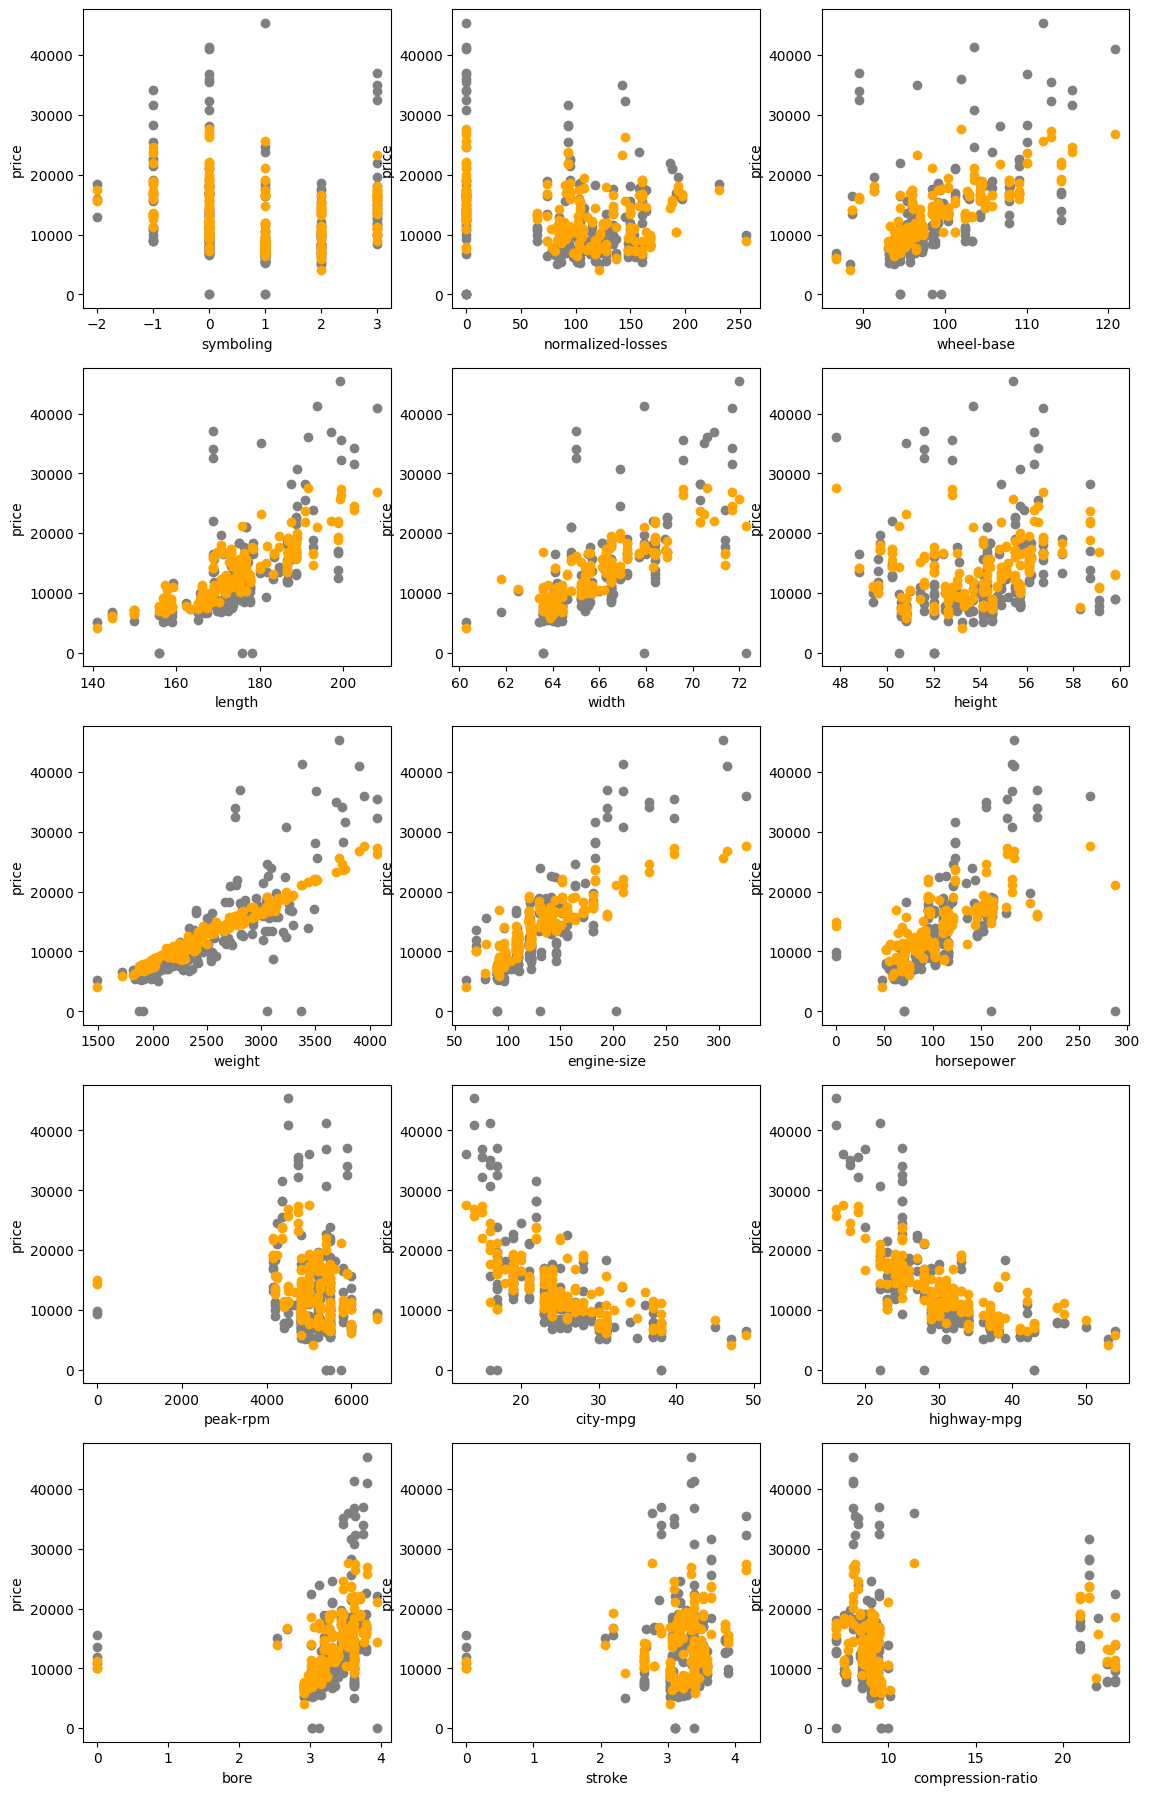

In [20]:
#@title Possible solution
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [21]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('mpfi', '2bbl', 'idi', '1bbl', '4bbl', 'spdi', 'spfi', 'mfi'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-location', vocabulary_list=('front', 'rear'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=Vocab

2023-06-30 17:07:29.226759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:29.227031: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpdjgablbu/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 3912398600.0, step = 1
INFO:tensorflow:global_step/sec: 431.979
INFO:tensorflow:loss = 3569214500.0, step = 101 (0.236 sec)
INFO:tensorflow:global_step/sec: 484.962
INFO:tensorflow:loss = 2252686300.0, step = 201 (0.206 sec)
INFO:tensorflow:global_step/sec: 372.483
INFO:tensorflow:loss = 5306723300.0, step = 301 (0.268 sec)
INFO:tensorflow:global_step/sec: 371.76
INFO:tensorflow:loss = 3384813000.0, step = 401 (0.269 sec)
INFO:tensorflow:global_step/sec: 365.821
INFO:tensorflow:loss = 4312771000.0, step = 501 (0.272 sec)
INFO:tensorflow:global_step/sec: 312.698
INFO:tensorflow:loss = 3368930300.0, step = 601 (0.323 sec)
INFO:tensorflow:global_step/sec: 281.298
INFO:tensorflow:loss = 4243106800.0, step = 701 (0.355 sec)
INFO:tensorflow:global_s

2023-06-30 17:07:33.512925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:33.513216: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.40191s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:33
INFO:tensorflow:Saving dict for global step 1000: average_loss = 224602140.0, global_step = 1000, label/mean = 12949.43, loss = 3541803000.0, prediction/mean = 318.9138
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpdjgablbu/model.ckpt-1000
scores {'average_loss': 224602140.0, 'label/mean': 12949.43, 'loss': 3541803000.0, 'prediction/mean': 318.9138, 'global_step': 1000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdjgablbu/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:34.545506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:34.545832: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...
INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpdjgablbu/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...
INFO:tensorflow:loss = 3572966400.0, step = 1001
INFO:tensorflow:global_step/sec: 339.79
INFO:tensorflow:loss = 1811555200.0, step = 1101 (0.299 sec)
INFO:tensorflow:global_step/sec: 456.76
INFO:tensorflow:loss = 4842549000.0, step = 1201 (0.216 sec)
INFO:tensorflow:global_step/sec: 394.083
INFO:tensorflow:loss = 4715972600.0, step = 1301 (0.256 sec)
INFO:tensorflow:global_step/sec: 346.913
INFO:tensorflow:loss = 3194688500.0, step = 1401 (0.290 sec)
INFO:tensorflow:global_step/sec: 425.657
INFO:tensorflow:loss = 4113457000.0, step = 1501 (0.233 sec)
INFO:tensorflow:global_step/sec: 398.225
INFO:tensorflow:loss = 3083284700.0, step = 1601 (0.258 sec)
INFO:tensorflow:global_step/sec: 378.841
INFO:tensorflow:loss = 5664216000.0, step = 1701 (0.256 sec)
INFO:t

2023-06-30 17:07:38.662037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:38.662453: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.46314s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:39
INFO:tensorflow:Saving dict for global step 2000: average_loss = 216996620.0, global_step = 2000, label/mean = 12949.43, loss = 3421869800.0, prediction/mean = 627.6422
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpdjgablbu/model.ckpt-2000
scores {'average_loss': 216996620.0, 'label/mean': 12949.43, 'loss': 3421869800.0, 'prediction/mean': 627.6422, 'global_step': 2000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdjgablbu/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:39.605320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:39.605654: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2000...
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpdjgablbu/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2000...
INFO:tensorflow:loss = 2830475000.0, step = 2001
INFO:tensorflow:global_step/sec: 375.907
INFO:tensorflow:loss = 3650594300.0, step = 2101 (0.267 sec)
INFO:tensorflow:global_step/sec: 467.354
INFO:tensorflow:loss = 3724392000.0, step = 2201 (0.215 sec)
INFO:tensorflow:global_step/sec: 441.47
INFO:tensorflow:loss = 2325894100.0, step = 2301 (0.225 sec)
INFO:tensorflow:global_step/sec: 417.923
INFO:tensorflow:loss = 3445996300.0, step = 2401 (0.240 sec)
INFO:tensorflow:global_step/sec: 409.187
INFO:tensorflow:loss = 2096438300.0, step = 2501 (0.244 sec)
INFO:tensorflow:global_step/sec: 401.753
INFO:tensorflow:loss = 3179192000.0, step = 2601 (0.249 sec)
INFO:tensorflow:global_step/sec: 432.188
INFO:tensorflow:loss = 2565850000.0, step = 2701 (0.231 sec)
INFO:

2023-06-30 17:07:43.474422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:43.474713: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.52607s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:43
INFO:tensorflow:Saving dict for global step 3000: average_loss = 209555760.0, global_step = 3000, label/mean = 12949.43, loss = 3304533000.0, prediction/mean = 937.36456
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /tmp/tmpdjgablbu/model.ckpt-3000
scores {'average_loss': 209555760.0, 'label/mean': 12949.43, 'loss': 3304533000.0, 'prediction/mean': 937.36456, 'global_step': 3000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdjgablbu/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:44.460767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:44.461061: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...
INFO:tensorflow:Saving checkpoints for 3000 into /tmp/tmpdjgablbu/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...
INFO:tensorflow:loss = 4318317600.0, step = 3001
INFO:tensorflow:global_step/sec: 365.804
INFO:tensorflow:loss = 5269181000.0, step = 3101 (0.276 sec)
INFO:tensorflow:global_step/sec: 401.139
INFO:tensorflow:loss = 2492834600.0, step = 3201 (0.249 sec)
INFO:tensorflow:global_step/sec: 459.865
INFO:tensorflow:loss = 4701835000.0, step = 3301 (0.217 sec)
INFO:tensorflow:global_step/sec: 449.307
INFO:tensorflow:loss = 4379818500.0, step = 3401 (0.223 sec)
INFO:tensorflow:global_step/sec: 436.036
INFO:tensorflow:loss = 2577711400.0, step = 3501 (0.230 sec)
INFO:tensorflow:global_step/sec: 417.889
INFO:tensorflow:loss = 1771250200.0, step = 3601 (0.239 sec)
INFO:tensorflow:global_step/sec: 442.219
INFO:tensorflow:loss = 1534302300.0, step = 3701 (0.226 sec)
INFO

2023-06-30 17:07:48.395397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:48.395703: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.43146s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:48
INFO:tensorflow:Saving dict for global step 4000: average_loss = 202402000.0, global_step = 4000, label/mean = 12949.43, loss = 3191723800.0, prediction/mean = 1242.7727
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: /tmp/tmpdjgablbu/model.ckpt-4000
scores {'average_loss': 202402000.0, 'label/mean': 12949.43, 'loss': 3191723800.0, 'prediction/mean': 1242.7727, 'global_step': 4000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdjgablbu/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:49.253824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:49.254173: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4000...
INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpdjgablbu/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4000...
INFO:tensorflow:loss = 5922076700.0, step = 4001
INFO:tensorflow:global_step/sec: 330.503
INFO:tensorflow:loss = 2013093600.0, step = 4101 (0.307 sec)
INFO:tensorflow:global_step/sec: 427.456
INFO:tensorflow:loss = 2266800000.0, step = 4201 (0.235 sec)
INFO:tensorflow:global_step/sec: 446.09
INFO:tensorflow:loss = 3049855000.0, step = 4301 (0.224 sec)
INFO:tensorflow:global_step/sec: 421.637
INFO:tensorflow:loss = 2712857000.0, step = 4401 (0.248 sec)
INFO:tensorflow:global_step/sec: 357.48
INFO:tensorflow:loss = 2465762300.0, step = 4501 (0.270 sec)
INFO:tensorflow:global_step/sec: 426.575
INFO:tensorflow:loss = 2864025900.0, step = 4601 (0.232 sec)
INFO:tensorflow:global_step/sec: 453.811
INFO:tensorflow:loss = 1582886500.0, step = 4701 (0.219 sec)
INFO:t

2023-06-30 17:07:53.390329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:53.390627: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.45370s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:53
INFO:tensorflow:Saving dict for global step 5000: average_loss = 195546260.0, global_step = 5000, label/mean = 12949.43, loss = 3083614000.0, prediction/mean = 1543.0327
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpdjgablbu/model.ckpt-5000
scores {'average_loss': 195546260.0, 'label/mean': 12949.43, 'loss': 3083614000.0, 'prediction/mean': 1543.0327, 'global_step': 5000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdjgablbu/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:54.312475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:54.312823: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5000...
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmpdjgablbu/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5000...
INFO:tensorflow:loss = 3818253800.0, step = 5001
INFO:tensorflow:global_step/sec: 345.179
INFO:tensorflow:loss = 3447142700.0, step = 5101 (0.292 sec)
INFO:tensorflow:global_step/sec: 377.478
INFO:tensorflow:loss = 1767210900.0, step = 5201 (0.267 sec)
INFO:tensorflow:global_step/sec: 393.578
INFO:tensorflow:loss = 1929573200.0, step = 5301 (0.251 sec)
INFO:tensorflow:global_step/sec: 449.302
INFO:tensorflow:loss = 2940764200.0, step = 5401 (0.223 sec)
INFO:tensorflow:global_step/sec: 408.891
INFO:tensorflow:loss = 4205198300.0, step = 5501 (0.245 sec)
INFO:tensorflow:global_step/sec: 366.623
INFO:tensorflow:loss = 1834085200.0, step = 5601 (0.274 sec)
INFO:tensorflow:global_step/sec: 419.132
INFO:tensorflow:loss = 1604652300.0, step = 5701 (0.237 sec)
INFO

2023-06-30 17:07:58.558970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:58.559225: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.42145s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:07:58
INFO:tensorflow:Saving dict for global step 6000: average_loss = 188972140.0, global_step = 6000, label/mean = 12949.43, loss = 2979945200.0, prediction/mean = 1838.4896
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /tmp/tmpdjgablbu/model.ckpt-6000
scores {'average_loss': 188972140.0, 'label/mean': 12949.43, 'loss': 2979945200.0, 'prediction/mean': 1838.4896, 'global_step': 6000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdjgablbu/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:07:59.904977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:07:59.905413: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...
INFO:tensorflow:Saving checkpoints for 6000 into /tmp/tmpdjgablbu/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...
INFO:tensorflow:loss = 2115859200.0, step = 6001
INFO:tensorflow:global_step/sec: 344.162
INFO:tensorflow:loss = 3025545700.0, step = 6101 (0.293 sec)
INFO:tensorflow:global_step/sec: 405.519
INFO:tensorflow:loss = 1436342300.0, step = 6201 (0.247 sec)
INFO:tensorflow:global_step/sec: 424.009
INFO:tensorflow:loss = 3339361800.0, step = 6301 (0.237 sec)
INFO:tensorflow:global_step/sec: 457.977
INFO:tensorflow:loss = 3782651400.0, step = 6401 (0.219 sec)
INFO:tensorflow:global_step/sec: 461.45
INFO:tensorflow:loss = 4345076700.0, step = 6501 (0.218 sec)
INFO:tensorflow:global_step/sec: 257.435
INFO:tensorflow:loss = 2984926000.0, step = 6601 (0.385 sec)
INFO:tensorflow:global_step/sec: 425.633
INFO:tensorflow:loss = 1422768600.0, step = 6701 (0.236 sec)
INFO:

2023-06-30 17:08:04.000020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:04.000300: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.48285s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:08:04
INFO:tensorflow:Saving dict for global step 7000: average_loss = 182673230.0, global_step = 7000, label/mean = 12949.43, loss = 2880616200.0, prediction/mean = 2129.031
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7000: /tmp/tmpdjgablbu/model.ckpt-7000
scores {'average_loss': 182673230.0, 'label/mean': 12949.43, 'loss': 2880616200.0, 'prediction/mean': 2129.031, 'global_step': 7000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdjgablbu/model.ckpt-7000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:05.004697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:05.005011: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7000...
INFO:tensorflow:Saving checkpoints for 7000 into /tmp/tmpdjgablbu/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7000...
INFO:tensorflow:loss = 3009601500.0, step = 7001
INFO:tensorflow:global_step/sec: 343.212
INFO:tensorflow:loss = 1301797600.0, step = 7101 (0.294 sec)
INFO:tensorflow:global_step/sec: 372.735
INFO:tensorflow:loss = 2279320000.0, step = 7201 (0.268 sec)
INFO:tensorflow:global_step/sec: 368.872
INFO:tensorflow:loss = 3468766700.0, step = 7301 (0.270 sec)
INFO:tensorflow:global_step/sec: 375.227
INFO:tensorflow:loss = 2602674700.0, step = 7401 (0.280 sec)
INFO:tensorflow:global_step/sec: 302.749
INFO:tensorflow:loss = 3016219100.0, step = 7501 (0.330 sec)
INFO:tensorflow:global_step/sec: 325.035
INFO:tensorflow:loss = 2264268300.0, step = 7601 (0.297 sec)
INFO:tensorflow:global_step/sec: 407.762
INFO:tensorflow:loss = 3465496000.0, step = 7701 (0.243 sec)
INFO

2023-06-30 17:08:09.269236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:09.269575: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.42587s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:08:09
INFO:tensorflow:Saving dict for global step 8000: average_loss = 176640700.0, global_step = 8000, label/mean = 12949.43, loss = 2785488000.0, prediction/mean = 2414.6838
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8000: /tmp/tmpdjgablbu/model.ckpt-8000
scores {'average_loss': 176640700.0, 'label/mean': 12949.43, 'loss': 2785488000.0, 'prediction/mean': 2414.6838, 'global_step': 8000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdjgablbu/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:10.175749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:10.176100: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8000...
INFO:tensorflow:Saving checkpoints for 8000 into /tmp/tmpdjgablbu/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...
INFO:tensorflow:loss = 2959221200.0, step = 8001
INFO:tensorflow:global_step/sec: 251.222
INFO:tensorflow:loss = 2819243800.0, step = 8101 (0.420 sec)
INFO:tensorflow:global_step/sec: 313.754
INFO:tensorflow:loss = 1558897800.0, step = 8201 (0.299 sec)
INFO:tensorflow:global_step/sec: 404.726
INFO:tensorflow:loss = 4205249000.0, step = 8301 (0.246 sec)
INFO:tensorflow:global_step/sec: 436.196
INFO:tensorflow:loss = 3729129700.0, step = 8401 (0.231 sec)
INFO:tensorflow:global_step/sec: 417.759
INFO:tensorflow:loss = 4215202800.0, step = 8501 (0.239 sec)
INFO:tensorflow:global_step/sec: 442.15
INFO:tensorflow:loss = 2785304800.0, step = 8601 (0.228 sec)
INFO:tensorflow:global_step/sec: 391.977
INFO:tensorflow:loss = 1667578200.0, step = 8701 (0.254 sec)
INFO:

2023-06-30 17:08:14.675573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:14.675898: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.47032s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:08:15
INFO:tensorflow:Saving dict for global step 9000: average_loss = 170867950.0, global_step = 9000, label/mean = 12949.43, loss = 2694456300.0, prediction/mean = 2695.3845
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /tmp/tmpdjgablbu/model.ckpt-9000
scores {'average_loss': 170867950.0, 'label/mean': 12949.43, 'loss': 2694456300.0, 'prediction/mean': 2695.3845, 'global_step': 9000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdjgablbu/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:15.722217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:15.722604: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tmpdjgablbu/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...
INFO:tensorflow:loss = 1775902500.0, step = 9001
INFO:tensorflow:global_step/sec: 281.108
INFO:tensorflow:loss = 4555783000.0, step = 9101 (0.357 sec)
INFO:tensorflow:global_step/sec: 235.183
INFO:tensorflow:loss = 2909462800.0, step = 9201 (0.427 sec)
INFO:tensorflow:global_step/sec: 383.887
INFO:tensorflow:loss = 5682520600.0, step = 9301 (0.262 sec)
INFO:tensorflow:global_step/sec: 373.433
INFO:tensorflow:loss = 3462980400.0, step = 9401 (0.269 sec)
INFO:tensorflow:global_step/sec: 336.555
INFO:tensorflow:loss = 2792264200.0, step = 9501 (0.296 sec)
INFO:tensorflow:global_step/sec: 345.391
INFO:tensorflow:loss = 5670455300.0, step = 9601 (0.291 sec)
INFO:tensorflow:global_step/sec: 245.992
INFO:tensorflow:loss = 1650486000.0, step = 9701 (0.404 sec)
INFO

2023-06-30 17:08:20.400806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:20.401140: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.48318s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:08:20
INFO:tensorflow:Saving dict for global step 10000: average_loss = 165344420.0, global_step = 10000, label/mean = 12949.43, loss = 2607354000.0, prediction/mean = 2971.1726
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmpdjgablbu/model.ckpt-10000
scores {'average_loss': 165344420.0, 'label/mean': 12949.43, 'loss': 2607354000.0, 'prediction/mean': 2971.1726, 'global_step': 10000}


In [22]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('mpfi', '2bbl', 'idi', '1bbl', '4bbl', 'spdi', 'spfi', 'mfi'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-location', vocabulary_list=('front', 'rear'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='body-style', vocabulary_list=('hatchback', 'sedan', 'wagon', 'hardtop', 'convertible'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='aspiration', vocabulary_list=('turbo', 'std'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('audi', 'bmw', 'peugot', 'volvo', 'toyota', 'nissan', 'plymouth', 'subaru', 'mercedes-b

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:21.970453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:21.970836: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpi6fqqwn7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 4378286600.0, step = 1
INFO:tensorflow:global_step/sec: 218.529
INFO:tensorflow:loss = 1471554000.0, step = 101 (0.461 sec)
INFO:tensorflow:global_step/sec: 271.764
INFO:tensorflow:loss = 1199561700.0, step = 201 (0.368 sec)
INFO:tensorflow:global_step/sec: 278.506
INFO:tensorflow:loss = 299656260.0, step = 301 (0.360 sec)
INFO:tensorflow:global_step/sec: 276.237
INFO:tensorflow:loss = 1640396200.0, step = 401 (0.360 sec)
INFO:tensorflow:global_step/sec: 187.142
INFO:tensorflow:loss = 465845760.0, step = 501 (0.534 sec)
INFO:tensorflow:global_step/sec: 223.51
INFO:tensorflow:loss = 218208800.0, step = 601 (0.448 sec)
INFO:tensorflow:global_step/sec: 255.32
INFO:tensorflow:loss = 358265760.0, step = 701 (0.395 sec)
INFO:tensorflow:global_step/s

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-06-30T17:08:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:28.383469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:28.383740: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.56748s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:08:28
INFO:tensorflow:Saving dict for global step 1000: average_loss = 49103970.0, global_step = 1000, label/mean = 12949.43, loss = 774331800.0, prediction/mean = 13244.128
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpi6fqqwn7/model.ckpt-1000
scores {'average_loss': 49103970.0, 'label/mean': 12949.43, 'loss': 774331800.0, 'prediction/mean': 13244.128, 'global_step': 1000}
INFO:tensorflow:Calling model_fn.


/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:30.012086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:30.012365: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000...
INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tmpi6fqqwn7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000...
INFO:tensorflow:loss = 646320000.0, step = 1001
INFO:tensorflow:global_step/sec: 204.54
INFO:tensorflow:loss = 428948670.0, step = 1101 (0.491 sec)
INFO:tensorflow:global_step/sec: 254.726
INFO:tensorflow:loss = 1140882000.0, step = 1201 (0.392 sec)
INFO:tensorflow:global_step/sec: 216.11
INFO:tensorflow:loss = 514901800.0, step = 1301 (0.467 sec)
INFO:tensorflow:global_step/sec: 232.763
INFO:tensorflow:loss = 845642400.0, step = 1401 (0.426 sec)
INFO:tensorflow:global_step/sec: 240.873
INFO:tensorflow:loss = 382857900.0, step = 1501 (0.418 sec)
INFO:tensorflow:global_step/sec: 240.926
INFO:tensorflow:loss = 289938880.0, step = 1601 (0.411 sec)
INFO:tensorflow:global_step/sec: 244.163
INFO:tensorflow:loss = 427057950.0, step = 1701 (0.410 sec)
INFO:tensorfl

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-06-30T17:08:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:36.434345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:36.434676: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.56263s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:08:36
INFO:tensorflow:Saving dict for global step 2000: average_loss = 42979550.0, global_step = 2000, label/mean = 12949.43, loss = 677754500.0, prediction/mean = 13159.839
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpi6fqqwn7/model.ckpt-2000
scores {'average_loss': 42979550.0, 'label/mean': 12949.43, 'loss': 677754500.0, 'prediction/mean': 13159.839, 'global_step': 2000}
INFO:tensorflow:Calling model_fn.


/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:37.727093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:37.727407: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2000...
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpi6fqqwn7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2000...
INFO:tensorflow:loss = 552911360.0, step = 2001
INFO:tensorflow:global_step/sec: 164.943
INFO:tensorflow:loss = 711610700.0, step = 2101 (0.622 sec)
INFO:tensorflow:global_step/sec: 155.759
INFO:tensorflow:loss = 318883780.0, step = 2201 (0.631 sec)
INFO:tensorflow:global_step/sec: 168.092
INFO:tensorflow:loss = 142007360.0, step = 2301 (0.595 sec)
INFO:tensorflow:global_step/sec: 254.019
INFO:tensorflow:loss = 598592100.0, step = 2401 (0.393 sec)
INFO:tensorflow:global_step/sec: 248.878
INFO:tensorflow:loss = 770957200.0, step = 2501 (0.405 sec)
INFO:tensorflow:global_step/sec: 244.463
INFO:tensorflow:loss = 134094690.0, step = 2601 (0.409 sec)
INFO:tensorflow:global_step/sec: 270.115
INFO:tensorflow:loss = 712161150.0, step = 2701 (0.366 sec)
INFO:tensorf

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-06-30T17:08:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:44.191763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:44.192042: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.49670s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:08:44
INFO:tensorflow:Saving dict for global step 3000: average_loss = 38267024.0, global_step = 3000, label/mean = 12949.43, loss = 603441540.0, prediction/mean = 13135.486
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: /tmp/tmpi6fqqwn7/model.ckpt-3000
scores {'average_loss': 38267024.0, 'label/mean': 12949.43, 'loss': 603441540.0, 'prediction/mean': 13135.486, 'global_step': 3000}
INFO:tensorflow:Calling model_fn.


/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:45.903569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:45.903874: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3000...
INFO:tensorflow:Saving checkpoints for 3000 into /tmp/tmpi6fqqwn7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3000...
INFO:tensorflow:loss = 475413100.0, step = 3001
INFO:tensorflow:global_step/sec: 201.022
INFO:tensorflow:loss = 670033900.0, step = 3101 (0.501 sec)
INFO:tensorflow:global_step/sec: 322.931
INFO:tensorflow:loss = 931186600.0, step = 3201 (0.309 sec)
INFO:tensorflow:global_step/sec: 256.079
INFO:tensorflow:loss = 232498780.0, step = 3301 (0.390 sec)
INFO:tensorflow:global_step/sec: 266.455
INFO:tensorflow:loss = 513703100.0, step = 3401 (0.375 sec)
INFO:tensorflow:global_step/sec: 227.404
INFO:tensorflow:loss = 685618200.0, step = 3501 (0.442 sec)
INFO:tensorflow:global_step/sec: 266.808
INFO:tensorflow:loss = 407476800.0, step = 3601 (0.372 sec)
INFO:tensorflow:global_step/sec: 255.758
INFO:tensorflow:loss = 427463000.0, step = 3701 (0.389 sec)
INFO:tensorf

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-06-30T17:08:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:52.118824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:52.119250: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.51352s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:08:52
INFO:tensorflow:Saving dict for global step 4000: average_loss = 34591320.0, global_step = 4000, label/mean = 12949.43, loss = 545478500.0, prediction/mean = 13120.089
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: /tmp/tmpi6fqqwn7/model.ckpt-4000
scores {'average_loss': 34591320.0, 'label/mean': 12949.43, 'loss': 545478500.0, 'prediction/mean': 13120.089, 'global_step': 4000}
INFO:tensorflow:Calling model_fn.


/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:53.408196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:53.408490: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4000...
INFO:tensorflow:Saving checkpoints for 4000 into /tmp/tmpi6fqqwn7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4000...
INFO:tensorflow:loss = 764344700.0, step = 4001
INFO:tensorflow:global_step/sec: 175.646
INFO:tensorflow:loss = 761714800.0, step = 4101 (0.573 sec)
INFO:tensorflow:global_step/sec: 224.419
INFO:tensorflow:loss = 634414200.0, step = 4201 (0.445 sec)
INFO:tensorflow:global_step/sec: 242.235
INFO:tensorflow:loss = 1029951040.0, step = 4301 (0.413 sec)
INFO:tensorflow:global_step/sec: 299.671
INFO:tensorflow:loss = 987369340.0, step = 4401 (0.334 sec)
INFO:tensorflow:global_step/sec: 253.146
INFO:tensorflow:loss = 637111300.0, step = 4501 (0.395 sec)
INFO:tensorflow:global_step/sec: 249.914
INFO:tensorflow:loss = 783396740.0, step = 4601 (0.400 sec)
INFO:tensorflow:global_step/sec: 304.882
INFO:tensorflow:loss = 493399520.0, step = 4701 (0.328 sec)
INFO:tensor

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-06-30T17:08:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:08:59.309225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:08:59.309505: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.49968s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:08:59
INFO:tensorflow:Saving dict for global step 5000: average_loss = 31734610.0, global_step = 5000, label/mean = 12949.43, loss = 500430370.0, prediction/mean = 13141.362
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpi6fqqwn7/model.ckpt-5000
scores {'average_loss': 31734610.0, 'label/mean': 12949.43, 'loss': 500430370.0, 'prediction/mean': 13141.362, 'global_step': 5000}
INFO:tensorflow:Calling model_fn.


/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:09:00.686877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:09:00.687173: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5000...
INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmpi6fqqwn7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5000...
INFO:tensorflow:loss = 298213120.0, step = 5001
INFO:tensorflow:global_step/sec: 249.115
INFO:tensorflow:loss = 453707230.0, step = 5101 (0.405 sec)
INFO:tensorflow:global_step/sec: 285.078
INFO:tensorflow:loss = 394475520.0, step = 5201 (0.352 sec)
INFO:tensorflow:global_step/sec: 309.905
INFO:tensorflow:loss = 177716560.0, step = 5301 (0.321 sec)
INFO:tensorflow:global_step/sec: 321.375
INFO:tensorflow:loss = 132600776.0, step = 5401 (0.311 sec)
INFO:tensorflow:global_step/sec: 272.854
INFO:tensorflow:loss = 1254814200.0, step = 5501 (0.367 sec)
INFO:tensorflow:global_step/sec: 294.381
INFO:tensorflow:loss = 341228800.0, step = 5601 (0.340 sec)
INFO:tensorflow:global_step/sec: 286.797
INFO:tensorflow:loss = 748766600.0, step = 5701 (0.348 sec)
INFO:tensor

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-06-30T17:09:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:09:06.022502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:09:06.022754: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.48444s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:09:06
INFO:tensorflow:Saving dict for global step 6000: average_loss = 29560092.0, global_step = 6000, label/mean = 12949.43, loss = 466139940.0, prediction/mean = 13188.915
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: /tmp/tmpi6fqqwn7/model.ckpt-6000
scores {'average_loss': 29560092.0, 'label/mean': 12949.43, 'loss': 466139940.0, 'prediction/mean': 13188.915, 'global_step': 6000}
INFO:tensorflow:Calling model_fn.


/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:09:07.253036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:09:07.253350: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6000...
INFO:tensorflow:Saving checkpoints for 6000 into /tmp/tmpi6fqqwn7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6000...
INFO:tensorflow:loss = 470749900.0, step = 6001
INFO:tensorflow:global_step/sec: 203.609
INFO:tensorflow:loss = 485381440.0, step = 6101 (0.495 sec)
INFO:tensorflow:global_step/sec: 249.37
INFO:tensorflow:loss = 130018270.0, step = 6201 (0.401 sec)
INFO:tensorflow:global_step/sec: 227.483
INFO:tensorflow:loss = 466740380.0, step = 6301 (0.439 sec)
INFO:tensorflow:global_step/sec: 241.847
INFO:tensorflow:loss = 142367250.0, step = 6401 (0.414 sec)
INFO:tensorflow:global_step/sec: 255.479
INFO:tensorflow:loss = 330489950.0, step = 6501 (0.393 sec)
INFO:tensorflow:global_step/sec: 249.641
INFO:tensorflow:loss = 430131550.0, step = 6601 (0.400 sec)
INFO:tensorflow:global_step/sec: 242.864
INFO:tensorflow:loss = 215215710.0, step = 6701 (0.411 sec)
INFO:tensorfl

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-06-30T17:09:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-7000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:09:13.786657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:09:13.787014: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.55364s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:09:14
INFO:tensorflow:Saving dict for global step 7000: average_loss = 27909088.0, global_step = 7000, label/mean = 12949.43, loss = 440104830.0, prediction/mean = 13133.906
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7000: /tmp/tmpi6fqqwn7/model.ckpt-7000
scores {'average_loss': 27909088.0, 'label/mean': 12949.43, 'loss': 440104830.0, 'prediction/mean': 13133.906, 'global_step': 7000}
INFO:tensorflow:Calling model_fn.


/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-7000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:09:15.123658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:09:15.124017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7000...
INFO:tensorflow:Saving checkpoints for 7000 into /tmp/tmpi6fqqwn7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7000...
INFO:tensorflow:loss = 1284840000.0, step = 7001
INFO:tensorflow:global_step/sec: 199.587
INFO:tensorflow:loss = 132346960.0, step = 7101 (0.504 sec)
INFO:tensorflow:global_step/sec: 243.838
INFO:tensorflow:loss = 235246080.0, step = 7201 (0.411 sec)
INFO:tensorflow:global_step/sec: 264.962
INFO:tensorflow:loss = 398390800.0, step = 7301 (0.381 sec)
INFO:tensorflow:global_step/sec: 232.666
INFO:tensorflow:loss = 227096020.0, step = 7401 (0.429 sec)
INFO:tensorflow:global_step/sec: 247.727
INFO:tensorflow:loss = 64392050.0, step = 7501 (0.408 sec)
INFO:tensorflow:global_step/sec: 238.407
INFO:tensorflow:loss = 112311330.0, step = 7601 (0.412 sec)
INFO:tensorflow:global_step/sec: 251.957
INFO:tensorflow:loss = 507848670.0, step = 7701 (0.397 sec)
INFO:tensorf

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-06-30T17:09:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:09:21.458851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:09:21.459146: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.54990s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:09:21
INFO:tensorflow:Saving dict for global step 8000: average_loss = 26676998.0, global_step = 8000, label/mean = 12949.43, loss = 420675740.0, prediction/mean = 13108.699
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8000: /tmp/tmpi6fqqwn7/model.ckpt-8000
scores {'average_loss': 26676998.0, 'label/mean': 12949.43, 'loss': 420675740.0, 'prediction/mean': 13108.699, 'global_step': 8000}
INFO:tensorflow:Calling model_fn.


/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:09:22.804649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:09:22.804949: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8000...
INFO:tensorflow:Saving checkpoints for 8000 into /tmp/tmpi6fqqwn7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8000...
INFO:tensorflow:loss = 955656700.0, step = 8001
INFO:tensorflow:global_step/sec: 198.092
INFO:tensorflow:loss = 540763500.0, step = 8101 (0.508 sec)
INFO:tensorflow:global_step/sec: 279.078
INFO:tensorflow:loss = 236756340.0, step = 8201 (0.358 sec)
INFO:tensorflow:global_step/sec: 242.123
INFO:tensorflow:loss = 106102300.0, step = 8301 (0.418 sec)
INFO:tensorflow:global_step/sec: 245.467
INFO:tensorflow:loss = 202199060.0, step = 8401 (0.403 sec)
INFO:tensorflow:global_step/sec: 279.613
INFO:tensorflow:loss = 669930800.0, step = 8501 (0.358 sec)
INFO:tensorflow:global_step/sec: 266.175
INFO:tensorflow:loss = 326978500.0, step = 8601 (0.376 sec)
INFO:tensorflow:global_step/sec: 262.784
INFO:tensorflow:loss = 317292000.0, step = 8701 (0.380 sec)
INFO:tensorf

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-06-30T17:09:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:09:29.098641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:09:29.098969: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.55629s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:09:29
INFO:tensorflow:Saving dict for global step 9000: average_loss = 25761358.0, global_step = 9000, label/mean = 12949.43, loss = 406236800.0, prediction/mean = 13181.871
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9000: /tmp/tmpi6fqqwn7/model.ckpt-9000
scores {'average_loss': 25761358.0, 'label/mean': 12949.43, 'loss': 406236800.0, 'prediction/mean': 13181.871, 'global_step': 9000}
INFO:tensorflow:Calling model_fn.


/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:09:30.348932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:09:30.349516: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9000...
INFO:tensorflow:Saving checkpoints for 9000 into /tmp/tmpi6fqqwn7/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9000...
INFO:tensorflow:loss = 353081400.0, step = 9001
INFO:tensorflow:global_step/sec: 214.812
INFO:tensorflow:loss = 489554750.0, step = 9101 (0.470 sec)
INFO:tensorflow:global_step/sec: 251.701
INFO:tensorflow:loss = 142212300.0, step = 9201 (0.396 sec)
INFO:tensorflow:global_step/sec: 272.222
INFO:tensorflow:loss = 1120805600.0, step = 9301 (0.367 sec)
INFO:tensorflow:global_step/sec: 278.585
INFO:tensorflow:loss = 320598240.0, step = 9401 (0.360 sec)
INFO:tensorflow:global_step/sec: 271.684
INFO:tensorflow:loss = 768708350.0, step = 9501 (0.368 sec)
INFO:tensorflow:global_step/sec: 255.338
INFO:tensorflow:loss = 1467367800.0, step = 9601 (0.392 sec)
INFO:tensorflow:global_step/sec: 258.245
INFO:tensorflow:loss = 585079800.0, step = 9701 (0.386 sec)
INFO:tenso

/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
/tmp/ipykernel_335404/3210164889.py:36: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to Fal

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-06-30T17:09:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpi6fqqwn7/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2023-06-30 17:09:36.411215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:09:36.411478: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Inference Time : 0.53965s
INFO:tensorflow:Finished evaluation at 2023-06-30-17:09:36
INFO:tensorflow:Saving dict for global step 10000: average_loss = 25073396.0, global_step = 10000, label/mean = 12949.43, loss = 395388200.0, prediction/mean = 13057.442
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/tmpi6fqqwn7/model.ckpt-10000
scores {'average_loss': 25073396.0, 'label/mean': 12949.43, 'loss': 395388200.0, 'prediction/mean': 13057.442, 'global_step': 10000}
